### Create test data to check implementation of HMM
Creates data under the model!

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import socket as socket
import os as os
import sys as sys
import multiprocessing as mp
import h5py
import allel
import itertools as it
import pickle

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/hapBLOCK/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)

print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

compute-a-17-93.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/hapBLOCK
CPU Count: 32


### Create Array of Means

In [152]:
def draw_normal_all_freqs(l=5000, mean=0.5, std=0.1):
    """Draw Normally distributed allele frequencies"""
    p = np.random.normal(size=l, loc=mean, scale=std)
    return p

def draw_haplotype(p):
    """Draw binomal haplotype from allele frequency p.
    For each locus draw one genotype
    Assumes Hardy Weinbgerg."""
    l = len(p)
    s = np.random.random(size=l)<p
    return s

def create_hap_ll(h):
    """Create vector of haplotype likelihood.
    Without error. 
    h: Haplotype vector [l,2] consisting of 0/1 post. prob"""
    l = np.zeros((len(h),2), dtype="bool")
    idx_der = (h==1)
    l[idx_der, 1] = 1
    l[~idx_der, 0] = 1
    return l

def add_haplo_rnd_error(h, eps=0.01):
    """Modify array of haplotyp post [l,2].
    Add random error and return array
    [l,2] of new haplotype posterior"""
    h = h * (1 - eps) + np.roll(h, shift=1, axis=1) * eps
    return h
    
def copy_in_block(h_s, h_t, loc=[10,20]):
    """Copy in Haplotype block by copying segment.
    h_s: The source haplotype
    h_t: The target haplotype
    loc: Location of haplotype to copy over"""
    h_t[loc[0]:loc[1]]=h_s[loc[0]:loc[1]]
    return h_t

def create_ibd_haplos(l=10000, loc=[2000,4000], mean=0.5, std=0.1, eps=0):
    """Create haplotype likelihoods with IBD copying.
    Draw allele frequencies, create HW haplotypes, copy in haplotype
    and create likelihoods.
    Return p [l] and haplotypelikelihoods [4,l,2]"""
    p = draw_normal_all_freqs(l=l, mean=mean, std=std)
    hts = [draw_haplotype(p) for _ in range(4)]
    hts[0] = copy_in_block(h_s=hts[2], h_t=hts[0], loc=loc)
    htsl = np.array([create_hap_ll(h) for h in hts])
    htsl = np.array([add_haplo_rnd_error(h, eps=eps) for h in htsl])
    return p, htsl

def save_haplo_ll(hts, p=[], folder="./output/simulated/undermodel/",
                  delimiter='\t'):
    """Save Haplotype Likelihoods in standardized format."""
    if not os.path.exists(folder):
        os.makedirs(folder)
    savepath = os.path.join(folder,"haplo_ll.tsv")
    pickle.dump(hts, open(savepath, "wb") )
    #np.savetxt(savepath, hts, delimiter=delimiter)
    print(f"Saved {np.shape(hts)[1]} loci likelihoods to {savepath}")
    
    if len(p)>0:
        savepath = os.path.join(folder,"p.tsv")
        np.savetxt(savepath, p, delimiter=delimiter)
        print(f"Saved {len(p)} allele frequencies to {savepath}")

def shuffle_haplos(h1, h2, scale=20):
    """Shuffle hapolotypes with random waiting times 
    (mean scale, exponentially distributed)"""
    hn1, hn2 = np.copy(h1), np.copy(h2)
    l=len(h1)
    w = np.random.exponential(scale=scale,size=l)
    w = np.round(w).astype("int")
    w = np.cumsum(w)
    s=0
    for i in range(len(w)):
        a,b=w[i],w[i+1]
        #print(f"shuffling from {a}-{b}")
        if b>l:
            break
        if (i%2)==1: # Only every other is shuffled
            hn1[a:b],hn2[a:b] = h2[a:b],h1[a:b]
        s+=1
    print(f"Total shuffles: {s}")
    return hn1,hn2

### Test single Haplotype

In [154]:
p = draw_normal_all_freqs(l=10000, mean=0.5, std=0.1)
assert((np.min(p)>0) and (np.max(p)<1)) # Sanity Check

### Draw random Haplotype
h0 = draw_haplotype(p)
print(f"Number of derived variants: {np.sum(h0)} / {len(h0)}")
l0 = create_hap_ll(h0)
print(f"Number of derived variants haplotype ll: {np.sum(l0[:,1])} / {len(l0)}")

Number of derived variants: 4910 / 10000
Number of derived variants haplotype ll: 4910 / 10000


### Create IBD sharing

In [155]:
%%time
p, htsl = create_ibd_haplos(l=10000, loc=[2000,4000], mean=0.5, std=0.1, eps=0.05)
np.sum(htsl,axis=2).all()

CPU times: user 6.97 ms, sys: 1.17 ms, total: 8.13 ms
Wall time: 6.51 ms


True

In [156]:
### Shuffle Haplotypes if needed, to create phase switches
htsl[0],htsl[1] = shuffle_haplos(htsl[0],htsl[1], scale=10)
htsl[2],htsl[3] = shuffle_haplos(htsl[2],htsl[3], scale=10)

Total shuffles: 990
Total shuffles: 984


In [157]:
save_haplo_ll(hts=htsl, p=p, folder="./output/simulated/undermodel/sim5/")

Saved 10000 loci likelihoods to ./output/simulated/undermodel/sim5/haplo_ll.tsv
Saved 10000 allele frequencies to ./output/simulated/undermodel/sim5/p.tsv


# Area 51

### Test load the saved the data

In [29]:
#htsl1 = pickle.load("./output/simulated/undermodel/sim1/haplo_ll.tsv", delimiter="\t", dtype="float")
htsl1 = pickle.load(open("./output/simulated/undermodel/sim1/haplo_ll.tsv", "rb")) 
#htsl1 = np.loadtxt("./output/simulated/undermodel/sim1/haplo_ll.tsv", delimiter="\t", dtype="float")
p1 = np.loadtxt("./output/simulated/undermodel/sim1/p.tsv", delimiter="\t", dtype="float")

In [66]:
mean, std = 0.5, 0.1
p = draw_normal_all_freqs(l=10000, mean=mean, std=std)
hts = [draw_haplotype(p) for _ in range(4)]
hts[0] = copy_in_block(h_s=hts[2], h_t=hts[0], loc=[2000,4000])

In [18]:
htsl = np.array([create_hap_ll(h) for h in hts])

In [36]:
t = htsl[0,:,:]

In [84]:
w

array([3.3000e+01, 1.3200e+02, 1.3800e+02, ..., 3.9310e+04, 3.9342e+04,
       3.9344e+04])

In [73]:
h0, h1 = htsl[0], htsl[1]

In [88]:
np.shape(h0)

(10000, 2)

In [137]:
h1 = np.zeros(1000)
h2 = np.ones(1000)

h1,h2 = shuffle_haplos(h1,h2,scale=50)

Total shuffles: 19


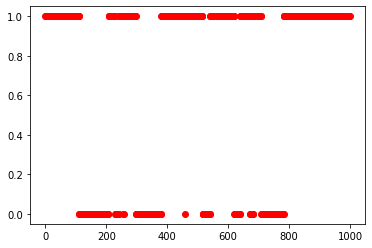

In [141]:
plt.figure()
ax=plt.gca()

ax.plot(np.arange(len(h1)), h2, "ro")

In [139]:
h1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.